# Datathon Cajamar UniversityHack 2022 - Cajamar Water Footprint

## Script Exploración - Equipo DPNA

## Imports y leer csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')    # Gráficos de mejor calidad

pd.options.display.max_info_rows = 30000000

sns.set_style('darkgrid')

# Tamaño figuras
plt.rcParams["figure.figsize"] = (15,6)

C:\Users\pablo\AppData\Local\Temp/ipykernel_13416/1655791511.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')    # Gráficos de mejor calidad


In [27]:
df = pd.read_csv('data/Modelar_UH2022.txt', sep='|', index_col='ID', parse_dates=True)
df.head()

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
0,2019-06-13 08:34:09,369320,0.0,17,0.0
0,2019-06-13 17:34:10,369403,0.0,2,0.0
0,2019-06-13 18:34:10,369403,0.0,0,0.0
0,2019-06-13 04:34:10,369284,0.0,1,0.0
0,2019-06-13 14:34:10,369356,0.0,28,0.0


In [9]:
df.index.drop_duplicates()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2739, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2756],
           dtype='int64', name='ID', length=2747)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21404828 entries, 0 to 2756
Data columns (total 5 columns):
 #   Column             Non-Null Count     Dtype  
---  ------             --------------     -----  
 0   SAMPLETIME         21404828 non-null  object 
 1   READINGINTEGER     21404828 non-null  int64  
 2   READINGTHOUSANDTH  21264772 non-null  float64
 3   DELTAINTEGER       21404828 non-null  int64  
 4   DELTATHOUSANDTH    21264772 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 979.8+ MB


In [28]:
df['SAMPLETIME'] = pd.to_datetime(df.SAMPLETIME)

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21404828 entries, 0 to 2756
Data columns (total 5 columns):
 #   Column             Non-Null Count     Dtype         
---  ------             --------------     -----         
 0   SAMPLETIME         21404828 non-null  datetime64[ns]
 1   READINGINTEGER     21404828 non-null  int64         
 2   READINGTHOUSANDTH  21264772 non-null  float64       
 3   DELTAINTEGER       21404828 non-null  int64         
 4   DELTATHOUSANDTH    21264772 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 979.8 MB


In [211]:
df.describe()

,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,2.140483e+07,2.126477e+07,2.140483e+07,2.126477e+07
mean,6.052178e+05,3.930737e+00,2.277017e+01,4.228367e+00
std,2.857464e+06,1.496893e+01,1.516794e+03,1.541059e+01
min,-6.407800e+04,0.000000e+00,-5.307340e+05,0.000000e+00
25%,6.368800e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.831570e+05,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.520500e+05,0.000000e+00,9.000000e+00,0.000000e+00
max,5.108976e+07,9.900000e+01,9.499810e+05,9.900000e+01


## ¿Valores perdidos?

### Visualización

Hay muchos contadores a los que les faltan datos. De hecho algunos solo tienen p.e. 4 entradas. También hay 4 con más entradas de las que deberían (8759) (aunque debería ser 8760)

In [157]:
df.groupby(['ID']).size().sort_values()

ID
2756        4
2747        4
2744        4
2743        4
2732        5
        ...  
998      8759
248     34956
1416    34970
292     35054
545     35076
Length: 2747, dtype: int64

<AxesSubplot:ylabel='Count'>

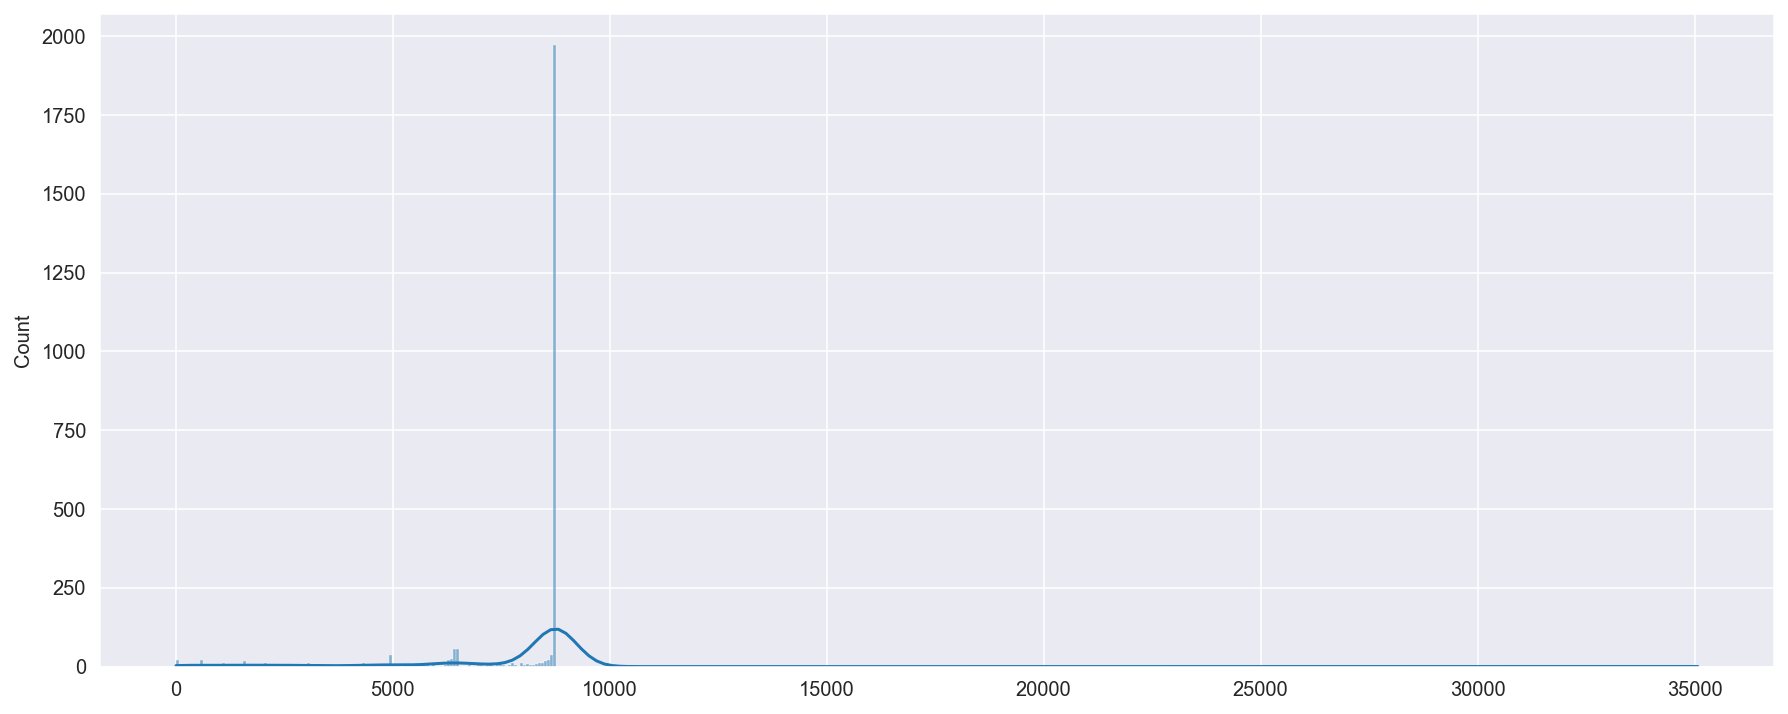

In [29]:
sns.histplot(df.groupby(['ID']).size().sort_values(), bins=500, kde=True)

<AxesSubplot:ylabel='Count'>

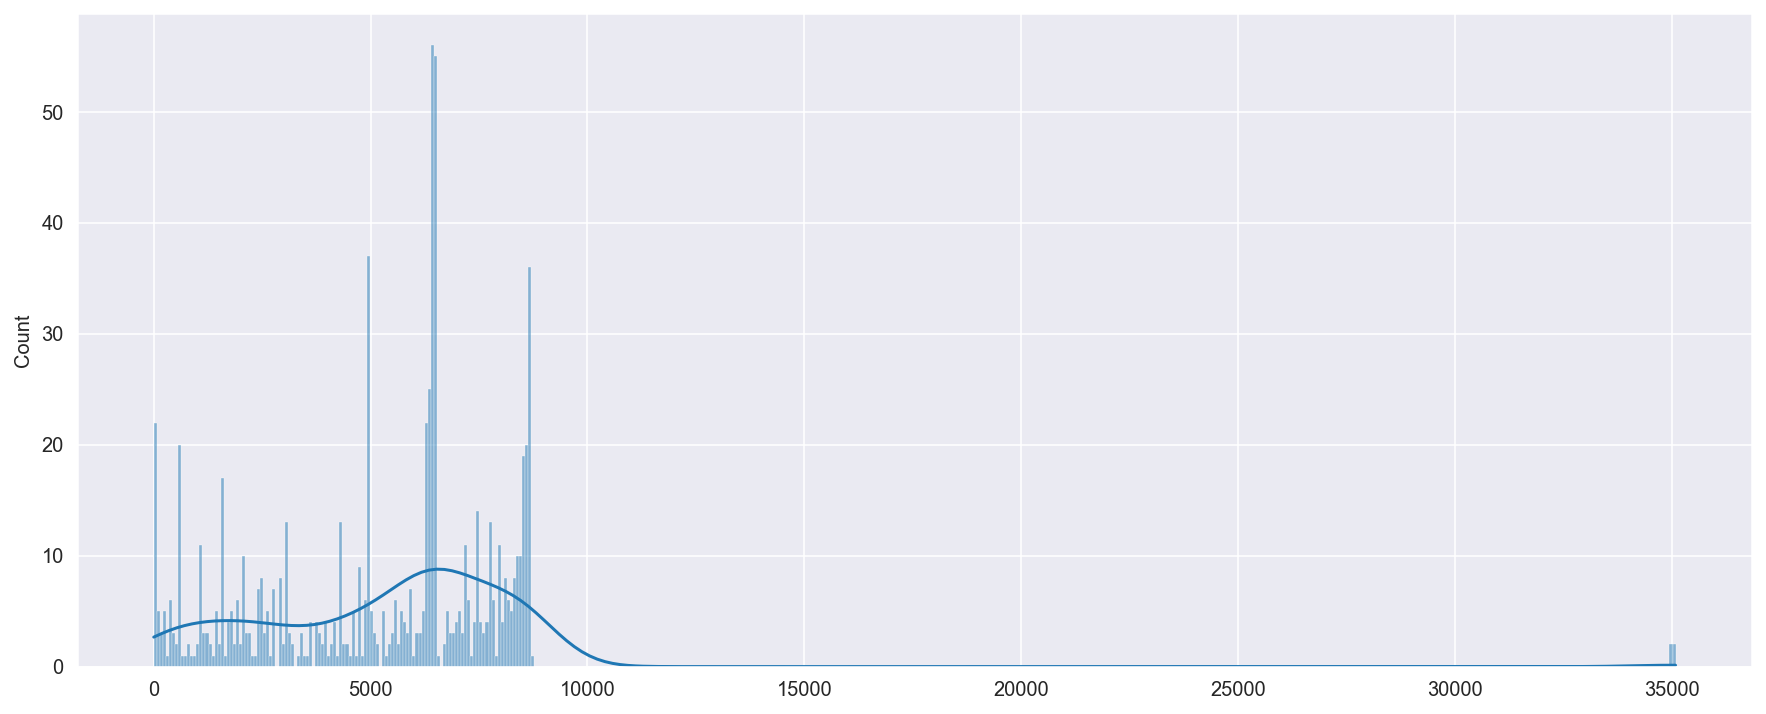

In [30]:
sns.histplot(df.groupby(['ID']).size().sort_values()[df.groupby(['ID']).size().sort_values() != 8759], bins=500, kde=True)

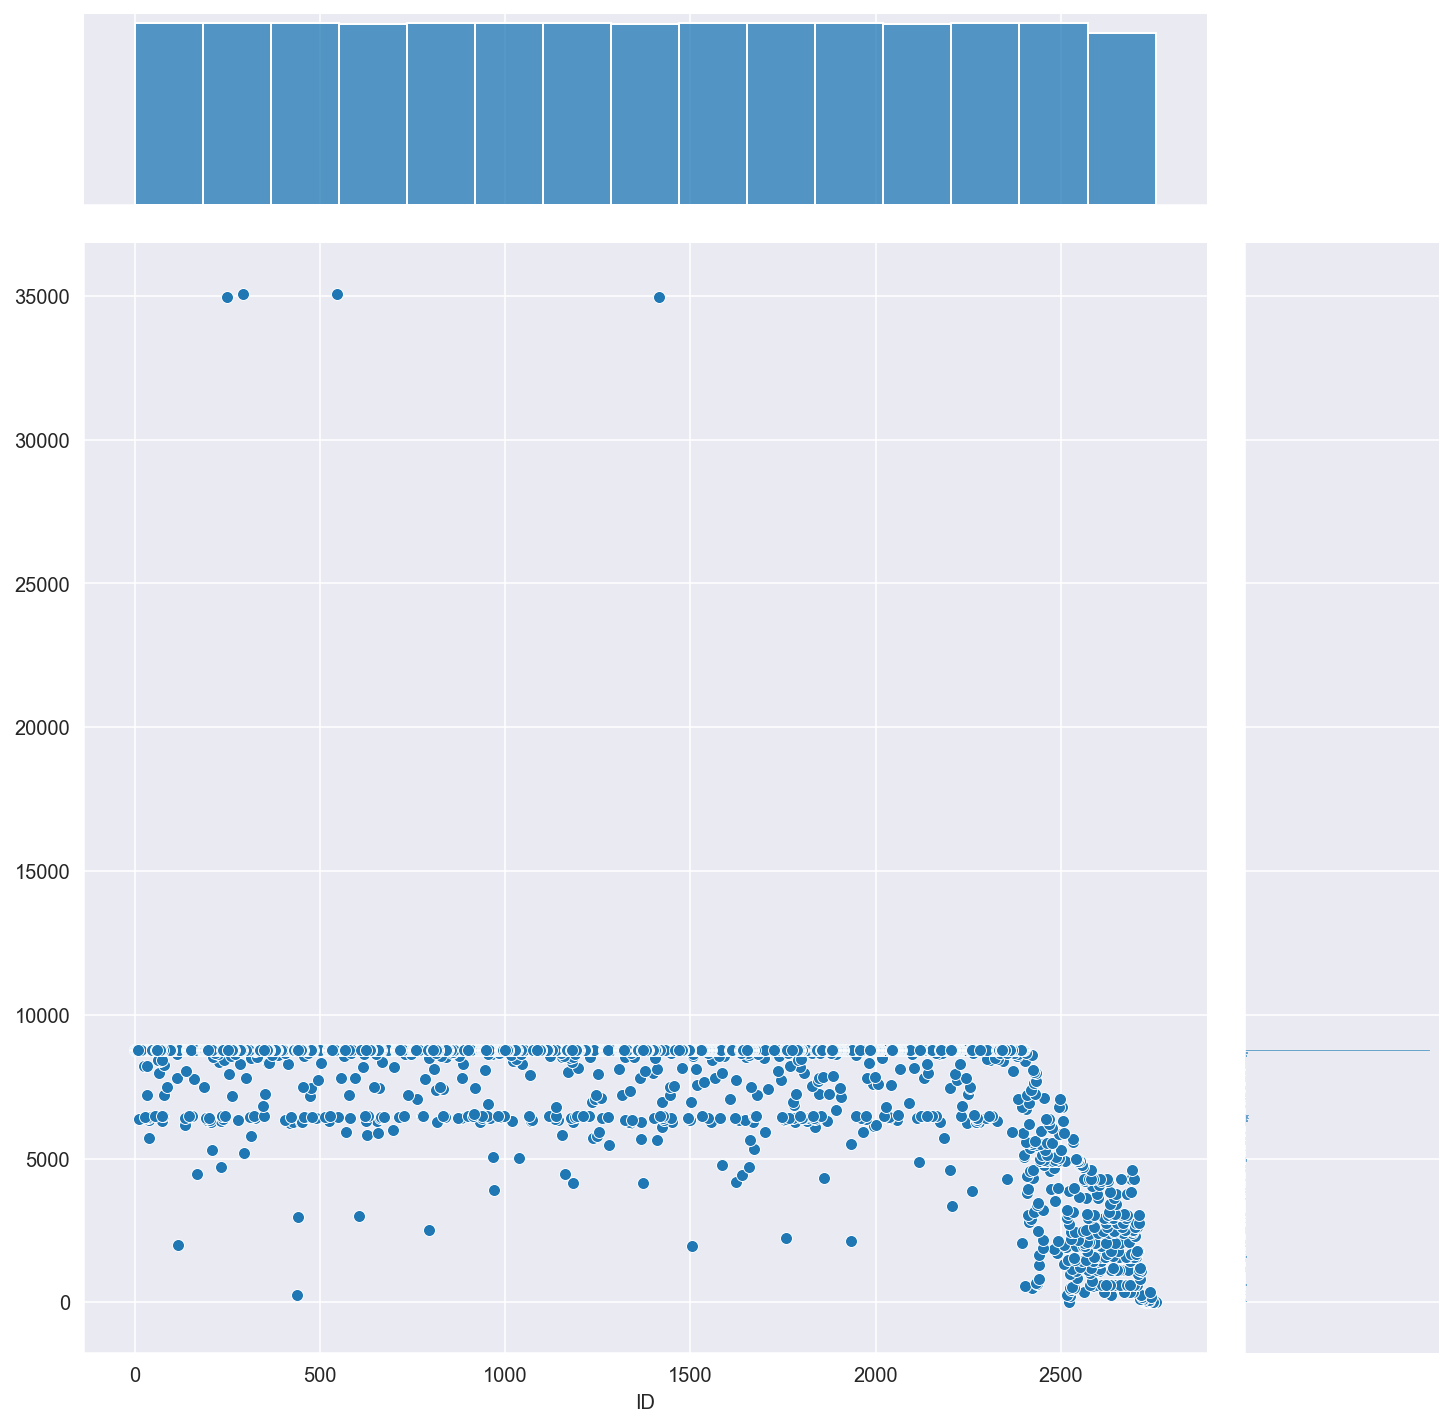

In [37]:
sns.jointplot(data=df.groupby(['ID']).size().sort_values(), kind='scatter', height=10)

La bajada de registros a partir del ID +- 2400 puede ser porque sean los últimos que se han añadido y no tengan registros desde el principio

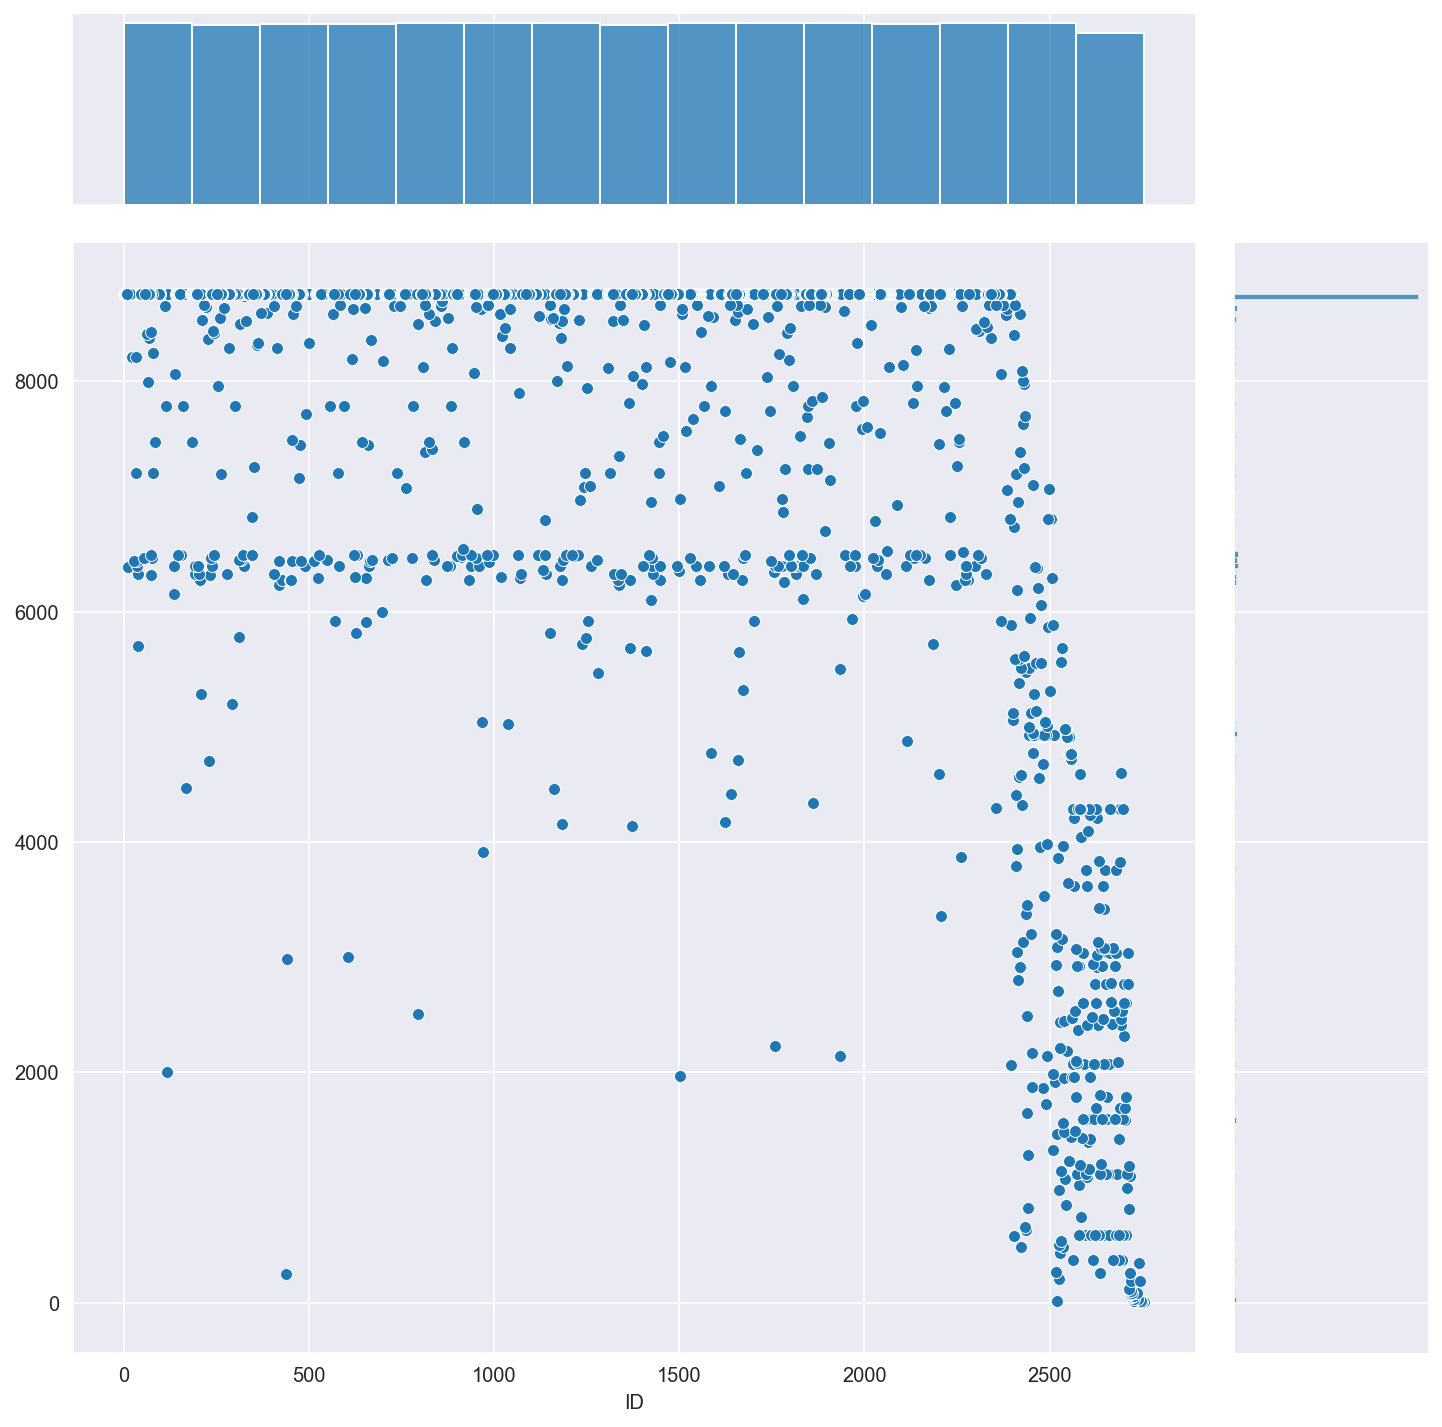

In [36]:
sns.jointplot(data=df.groupby(['ID']).size().sort_values()[:2743], kind='scatter', height=10)

In [102]:
df.groupby(['ID']).size().describe()

count     2747.000000
mean      7792.074263
std       2370.917299
min          4.000000
25%       8421.000000
50%       8759.000000
75%       8759.000000
max      35076.000000
dtype: float64

Parece que los que leen más (ID 248, 1416, 292, 545) es porque leen cada 15 minuos. Además tienen NaN en la parte decimal

In [12]:
df.loc[248]

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
248,2019-06-13 18:30:00,26752630,NaN,0,NaN
248,2019-06-13 04:30:00,26676570,NaN,3290,NaN
248,2019-06-13 16:30:00,26752630,NaN,0,NaN
248,2019-06-13 18:45:00,26752630,NaN,0,NaN
248,2019-06-13 09:45:00,26736300,NaN,2780,NaN
...,...,...,...,...,...
248,2020-01-25 09:30:00,35367090,NaN,0,NaN
248,2020-01-25 16:00:00,35367090,NaN,0,NaN
248,2020-01-25 11:00:00,35367090,NaN,0,NaN


En este caso por ejemplo solo hay datos del verano

In [17]:
df.loc[2530].sort_values('SAMPLETIME')

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
2530,2019-06-29 15:04:57,257019,0.0,0,0.0
2530,2019-06-29 16:04:57,257022,0.0,3,0.0
2530,2019-06-29 17:04:57,257022,0.0,0,0.0
2530,2019-06-29 18:04:57,257042,0.0,20,0.0
2530,2019-06-29 19:00:00,257045,29.0,3,29.0
...,...,...,...,...,...
2530,2019-08-31 18:02:44,265982,0.0,0,0.0
2530,2019-09-24 15:01:53,269306,0.0,0,0.0
2530,2019-09-24 16:01:53,269320,0.0,14,0.0


#### Comprobar para qué meses hay menos valores

2747 ID * 24 horas = 65.928 horas al día

Enero, Marzo, Mayo, Julio, Agosto, Octubre, Diciembre: 31 * 65.928 = 2.043.768 horas

Abril, Junio, Septiembre, Noviembre: 30 * 65.928 = 1.977.840 horas

Febrero: 28 * 65.928 = 1.845.984 horas

In [152]:
df2 = df.groupby(df.SAMPLETIME.dt.to_period('M')).agg("count")["SAMPLETIME"].to_frame()
s = pd.Series(12*['SAMPLETIME'])
df2['Tipo'] = s.values

df3 = df.groupby(df.SAMPLETIME.dt.to_period('M')).agg("count")["SAMPLETIME"].to_frame()
s = pd.Series([1845984,2043768,1977840,2043768,1977840,2043768,2043768,1977840,2043768,1977840,2043768,2043768])
df3['SAMPLETIME'] = s.values
s = pd.Series(12*["ESPERADO"])
df3['Tipo'] = s.values

df2 = pd.concat([df2, df3])
df2["Mes"] = df2.index
df2

,SAMPLETIME,Tipo,Mes
SAMPLETIME,,,
2019-02,1522985,SAMPLETIME,2019-02
2019-03,1701944,SAMPLETIME,2019-03
2019-04,1668736,SAMPLETIME,2019-04
2019-05,1771551,SAMPLETIME,2019-05
2019-06,1729785,SAMPLETIME,2019-06
2019-07,1802685,SAMPLETIME,2019-07
2019-08,1832859,SAMPLETIME,2019-08
2019-09,1760192,SAMPLETIME,2019-09
2019-10,1871522,SAMPLETIME,2019-10


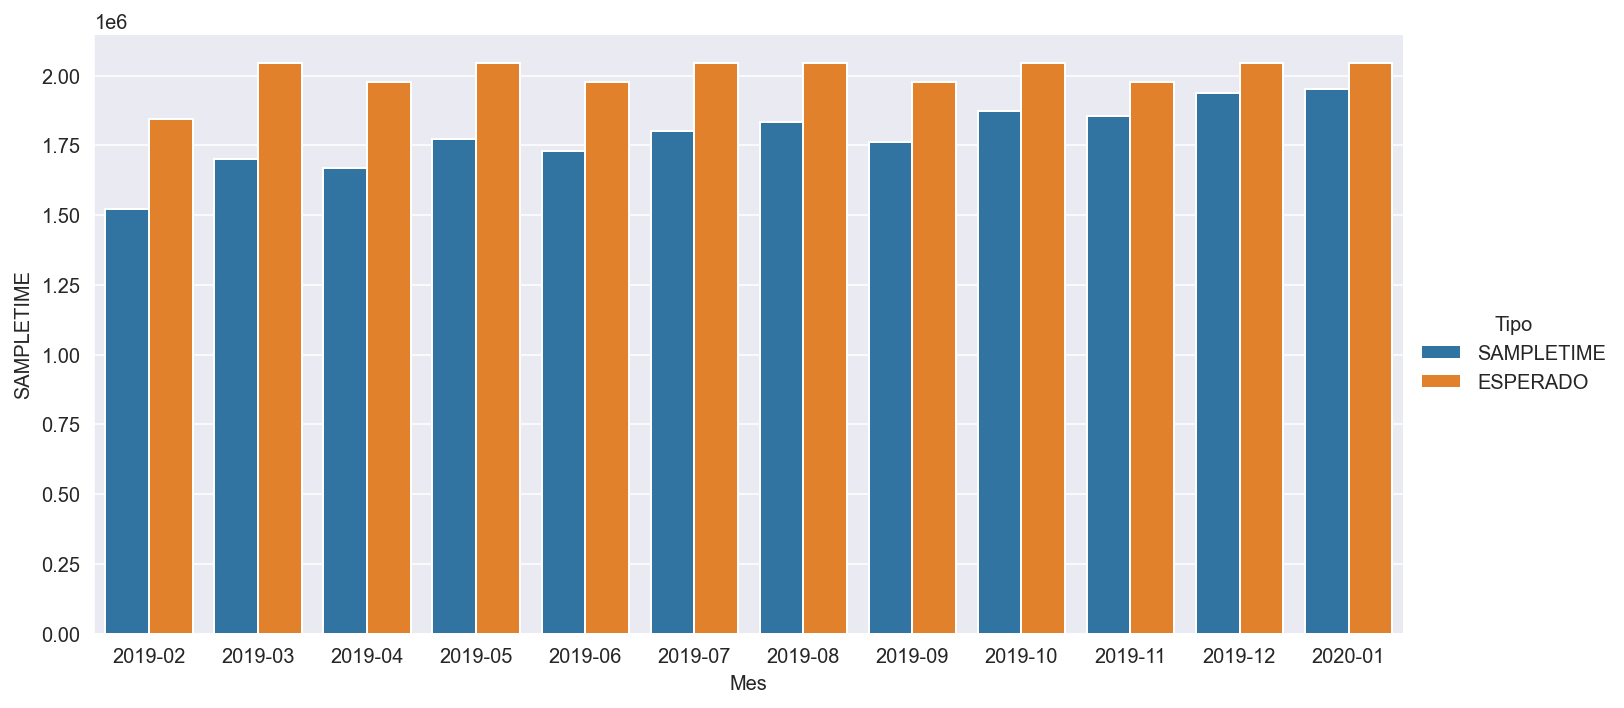

In [149]:
sns.catplot(data=df2, x='Mes', y='SAMPLETIME', kind='bar', hue='Tipo', aspect=2)

A veces no falta simplemente una hora, sino que podemos tener un dato a las 16:00, otro a las 17:30 y otro a las 19:00

## ¿Si sumamos los deltas enteros y decimales conseguimos la resta entre el máx y el min de READINGINTEGER?

En algunos casos el máx READINGTHOUSANDTH es +- 10 y en otros 100. P.e. en ID 0 el max es 8, y sale la cuenta al dividir entre 10

In [20]:
df_prueba = df.loc[0].sort_values('SAMPLETIME')
df_prueba.describe()

,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,8759.000000,8759.000000,8759.000000,8759.000000
mean,383306.944857,0.029684,11.784564,0.039959
std,29487.925728,0.421001,20.465775,0.506412
min,331710.000000,0.000000,0.000000,0.000000
25%,357061.500000,0.000000,0.000000,0.000000
50%,384652.000000,0.000000,3.000000,0.000000
75%,408658.500000,0.000000,15.000000,0.000000
max,434966.000000,8.000000,264.000000,8.000000


In [21]:
print(df_prueba["READINGINTEGER"].max() - df_prueba["READINGINTEGER"].min())

print(df_prueba["DELTAINTEGER"].sum())

print((df_prueba["DELTATHOUSANDTH"]/10).sum())

103256
103221
35.0


In [22]:
df_prueba["DELTA"] = df_prueba["DELTAINTEGER"] + df_prueba["DELTATHOUSANDTH"]/10
print(df_prueba["DELTA"].sum())
df_prueba.head(200)

103256.0


,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,DELTA
ID,,,,,,
0,2019-02-01 00:39:36,331710,0.0,0,0.0,0.0
0,2019-02-01 01:39:36,331710,0.0,0,0.0,0.0
0,2019-02-01 02:39:35,331710,0.0,0,0.0,0.0
0,2019-02-01 03:39:35,331710,0.0,0,0.0,0.0
0,2019-02-01 04:39:35,331710,0.0,0,0.0,0.0
...,...,...,...,...,...,...
0,2019-02-09 03:39:15,333744,0.0,0,0.0,0.0
0,2019-02-09 04:39:15,333744,0.0,0,0.0,0.0
0,2019-02-09 05:39:15,333744,0.0,0,0.0,0.0


Pero p.e. en ID 1 el max es 98, la cuenta debería ser dividir entre 100 pero no da exacto (porque para algunas horas sí habría que hacerlo entre 10)

In [6]:
df_prueba = df.loc[1].sort_values('SAMPLETIME')
df_prueba.describe()

,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
count,8759.000000,8759.000000,8759.000000,8759.000000
mean,8182.789930,4.137459,0.433497,3.580317
std,1204.641522,15.364374,3.008305,12.710341
min,5825.000000,0.000000,0.000000,0.000000
25%,7069.000000,0.000000,0.000000,0.000000
50%,8202.000000,0.000000,0.000000,0.000000
75%,9183.000000,0.000000,0.000000,0.000000
max,10092.000000,98.000000,108.000000,89.000000


In [7]:
print(df_prueba["READINGINTEGER"].max() - df_prueba["READINGINTEGER"].min())

print(df_prueba["DELTAINTEGER"].sum())

print((df_prueba["DELTATHOUSANDTH"]/100).sum())

4267
3797
313.59999999999997


In [13]:
df_prueba["DELTA"] = df_prueba["DELTAINTEGER"] + df_prueba["DELTATHOUSANDTH"]/100
print(df_prueba["DELTA"].sum())
print(df_prueba["READINGINTEGER"].max() - df_prueba["READINGINTEGER"].min())

pd.set_option('display.max_rows', 500)

df_prueba.head()#.iloc[:, [1,4,5]]

4110.6
4267


,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,DELTA
ID,,,,,,
1,2019-02-01 00:40:17,5825,0.0,0,0.0,0.0
1,2019-02-01 01:40:17,5825,0.0,0,0.0,0.0
1,2019-02-01 02:40:17,5825,0.0,0,0.0,0.0
1,2019-02-01 03:40:16,5825,0.0,0,0.0,0.0
1,2019-02-01 04:40:16,5825,0.0,0,0.0,0.0


In [8]:
df.index.drop_duplicates()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2739, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2756],
           dtype='int64', name='ID', length=2747)

Cuidado, hay casos que han puesto todos los números negativos

In [74]:
df.loc[2711].sort_values('SAMPLETIME').head(10)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
2711,2019-10-08 14:00:00,8345,-0.0,0,-0.0
2711,2019-10-08 15:00:00,8498,-0.0,153,-0.0
2711,2019-10-08 16:00:00,8592,-0.0,94,-0.0
2711,2019-10-08 17:00:00,8756,-0.0,164,-0.0
2711,2019-10-08 18:00:00,8856,-0.0,100,-0.0
2711,2019-10-08 19:00:00,8878,-0.0,22,-0.0
2711,2019-10-08 20:00:00,8879,-0.0,1,-0.0
2711,2019-10-08 21:00:00,8880,-0.0,1,-0.0
2711,2019-10-08 22:00:00,8880,-0.0,0,-0.0


¡El contador empieza a ir marcha atrás!

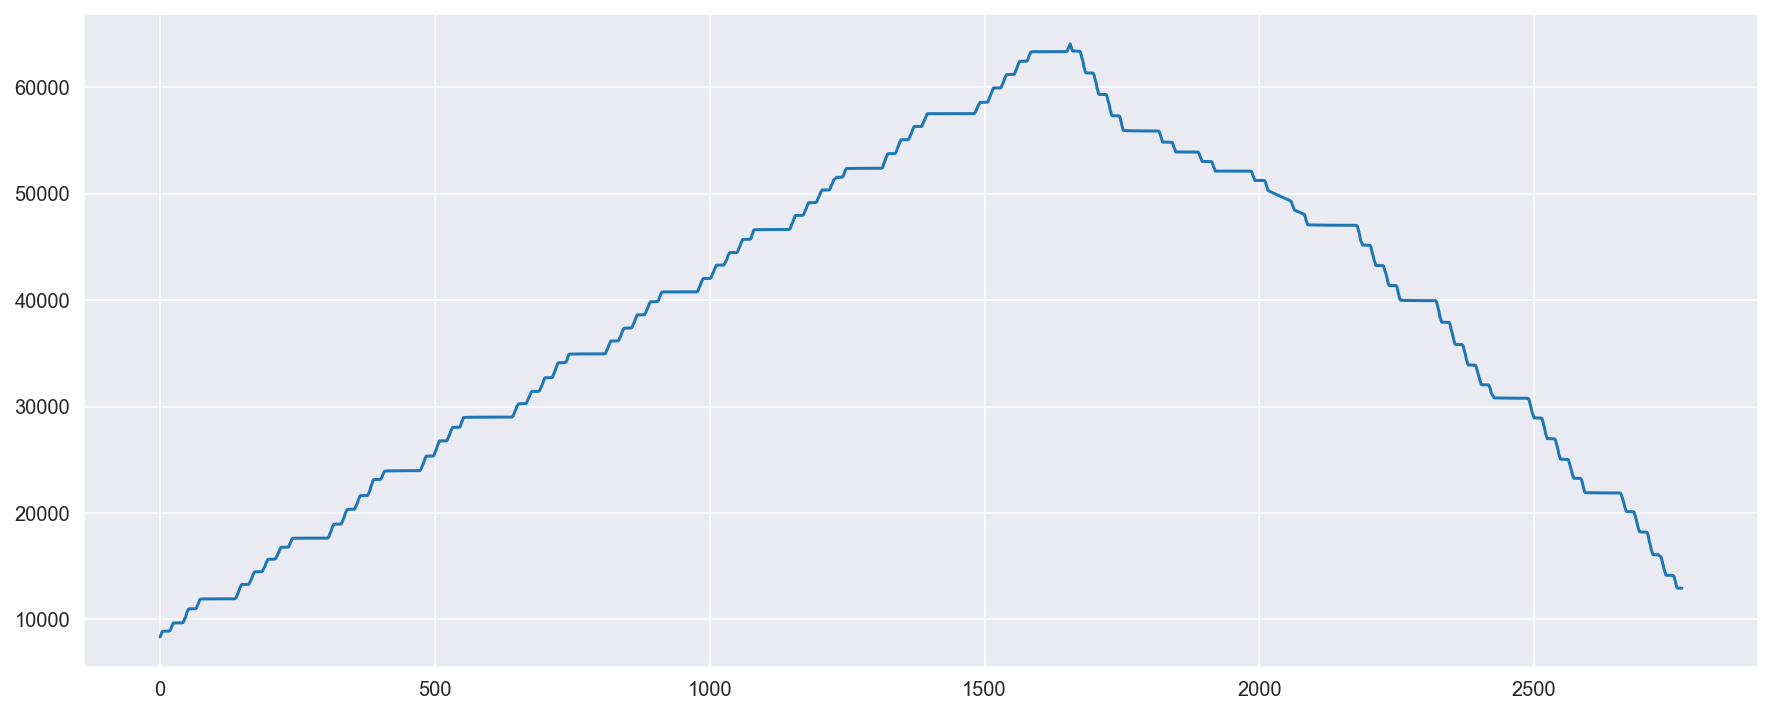

In [84]:
plt.plot(df.loc[2711].sort_values('SAMPLETIME')["READINGINTEGER"].values)

Imputar valores perdidos como 0

In [92]:
df.loc[248].sort_values('SAMPLETIME').head()

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
248,2019-02-01 00:00:00,20519620,NaN,10,NaN
248,2019-02-01 00:00:00,20519610,NaN,10,NaN
248,2019-02-01 00:00:00,20519600,NaN,0,NaN
248,2019-02-01 00:00:00,20519600,NaN,0,NaN
248,2019-02-01 01:00:00,20528660,NaN,3610,NaN


¡El delta está mal en algunos!

In [102]:
df.loc[2746].sort_values('SAMPLETIME').head(10)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
2746,2019-08-14 02:00:00,523869,-0.0,0,-0.0
2746,2019-08-14 03:00:00,523869,-0.0,0,-0.0
2746,2019-08-14 04:00:00,523869,-0.0,0,-0.0
2746,2019-08-14 05:00:00,523869,-0.0,0,-0.0
2746,2019-08-28 22:00:00,532612,-0.0,0,-0.0
2746,2019-08-28 23:00:00,532613,-0.0,1,-0.0
2746,2019-08-29 00:00:00,532613,-0.0,0,-0.0
2746,2019-08-29 01:00:00,532613,-0.0,0,-0.0


Cuando hay valores perdidos no nos sirve quedarnos con el delta

In [112]:
df.loc[2529].sort_values('SAMPLETIME').head(3000).tail(15)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
2529,2019-05-01 22:00:00,159647,26.0,15,25.0
2529,2019-05-01 23:00:00,159662,51.0,15,25.0
2529,2019-05-02 00:00:00,159677,75.0,15,25.0
2529,2019-05-02 01:00:00,159693,-0.0,15,25.0
2529,2019-05-02 02:00:00,159693,-0.0,0,-0.0
2529,2019-05-02 03:00:00,159693,-0.0,0,-0.0
2529,2019-05-02 04:00:00,159704,-0.0,11,-0.0
2529,2019-12-04 20:00:00,210933,-0.0,0,-0.0
2529,2019-12-04 21:00:00,211028,-0.0,95,-0.0


### Normalización

Primero vamos a cambiar de signo los valores negativos

In [29]:
df['READINGINTEGER'] = df['READINGINTEGER'].apply(lambda x : x if x >= 0 else -x)
df['READINGTHOUSANDTH'] = df['READINGTHOUSANDTH'].apply(lambda x : x if x >= 0 else -x)
df['DELTAINTEGER'] = df['DELTAINTEGER'].apply(lambda x : x if x >= 0 else -x)
df['DELTATHOUSANDTH'] = df['DELTATHOUSANDTH'].apply(lambda x : x if x >= 0 else -x)

E imputamos los valores perdidos

In [30]:
df.fillna(0, inplace=True)
df.loc[292].sort_values('SAMPLETIME').head(5)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
292,2019-02-01 00:00:00,17433250,0.0,320,0.0
292,2019-02-01 00:15:00,17433560,0.0,310,0.0
292,2019-02-01 00:30:00,17433880,0.0,320,0.0
292,2019-02-01 00:45:00,17434190,0.0,310,0.0
292,2019-02-01 01:00:00,17434820,0.0,630,0.0


In [214]:
#248
df_prueba = df.loc[1768].sort_values('SAMPLETIME')
print(df_prueba["READINGINTEGER"].max() - df_prueba["READINGINTEGER"].min())
print(df_prueba["DELTAINTEGER"].sum())
print((df_prueba["DELTATHOUSANDTH"]/100).sum())
df_prueba["DELTA"] = df_prueba["DELTAINTEGER"] + df_prueba["DELTATHOUSANDTH"]/100
print(df_prueba["DELTA"].sum())

pd.set_option('display.max_rows', 20)

df_prueba.head(20)#.iloc[:, [1,4,5]]

5099
5082
1.7000000000000002
5083.700000000001


,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH,DELTA
ID,,,,,,
1768,2019-02-01 00:59:01,4317,0.0,0,0.0,0.0
1768,2019-02-01 01:58:58,4317,0.0,0,0.0,0.0
1768,2019-02-01 02:58:58,4317,0.0,0,0.0,0.0
1768,2019-02-01 03:58:58,4317,0.0,0,0.0,0.0
1768,2019-02-01 04:58:58,4317,0.0,0,0.0,0.0
1768,2019-02-01 05:59:00,4317,0.0,0,0.0,0.0
1768,2019-02-01 06:59:00,4317,0.0,0,0.0,0.0
1768,2019-02-01 07:59:00,4317,0.0,0,0.0,0.0
1768,2019-02-01 08:59:00,4317,0.0,0,0.0,0.0


In [239]:
ok10 = 0; ok100 = 0; mal = 0

index = set()

for i in tqdm(df.index.drop_duplicates()):
    df_temp = df.loc[i].sort_values('SAMPLETIME')
    
    resta = df_temp["READINGINTEGER"].max() - df_temp["READINGINTEGER"].min()

    df_temp["DELTA"] = df_temp["DELTAINTEGER"] + df_temp["DELTATHOUSANDTH"]/10
    #print(df_temp["DELTA"].sum(), resta)
    if np.abs(df_temp["DELTA"].sum() - resta) < 1:
        ok10 = ok10 + 1
        index.add(i)
    
    else:
        #if (df_temp["DELTA"].sum() < resta):
        #    print(i, ": -- :", df_temp["DELTA"].sum(), resta)
        df_temp["DELTA"] = df_temp["DELTAINTEGER"] + df_temp["DELTATHOUSANDTH"]/100
        
        if np.abs(df_temp["DELTA"].sum() - resta) < 1:
            ok100 = ok100 + 1
            index.add(i)
        else:
            mal = mal + 1
    
print("OK 10:",ok10,"OK 100:",ok100,"MAL:",mal)
#OK 10: 423 OK 100: 1 MAL: 2323
#OK 10: 426 OK 100: 20 MAL: 2301
#OK 10: 377 OK 100: 19 MAL: 2351
#OK 10: 320 OK 100: 20 MAL: 2398


100%|██████████| 2738/2738 [00:04<00:00, 636.20it/s]

OK 10: 320 OK 100: 20 MAL: 2398


### Ver si READINTEGER es rotativo (en algún momento pasa a valer 0)

También si nos quedamos con la columna de reading o de delta

## Cada contador tiene horas distintas, que encima son "de su padre y de su madre"

Hay motivos para pensar que la parte de minutos:segundos realmente no influye

### Visualización

In [40]:
df.groupby(['SAMPLETIME']).size().count()

13516088

13516088 valores distintos de fecha/hora. Los tenemos que dejar en 8760

In [41]:
df.groupby(['SAMPLETIME']).size().describe()

count    1.351609e+07
mean     1.583656e+00
std      1.035941e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.101000e+03
dtype: float64

### Convertir tiempos a horas enteras (16:04:57 a 16)

Podemos probar estableciendo directamente los minutos y segundos a 0. Además, vamos a corregir las horas que aparecen 3, 4 y 5 veces como se puede ver abajo

In [31]:
df['SAMPLETIME'] = df['SAMPLETIME'].apply(lambda x:x.replace(minute=0,second=0))
df

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
0,2019-06-13 08:00:00,369320,0.0,17,0.0
0,2019-06-13 17:00:00,369403,0.0,2,0.0
0,2019-06-13 18:00:00,369403,0.0,0,0.0
0,2019-06-13 04:00:00,369284,0.0,1,0.0
0,2019-06-13 14:00:00,369356,0.0,28,0.0
...,...,...,...,...,...
2749,2019-10-11 06:00:00,164505,0.0,0,0.0
2756,2019-04-06 05:00:00,349758,0.0,0,0.0
2756,2019-04-06 07:00:00,349770,0.0,12,0.0


Empezamos con la más fácil, cuando hay 4 horas. Aquí, tenemos las horas :00, :15, :30 y :45. También cuando tenemos 3 horas, ya que es un caso similar.

In [32]:
df_temp = df.groupby(['ID','SAMPLETIME']).size().sort_values()
unique2, counts2 = np.unique(df_temp, return_counts=True)
dict(zip(unique2, counts2))

{1: 21264774, 3: 2, 4: 34882, 5: 104}

In [33]:
df_borrar = df_temp[(df_temp == 4) | (df_temp == 3)].sort_index().to_frame()
df_borrar

0
ID   SAMPLETIME            
248  2019-02-01 00:00:00  4
     2019-02-01 01:00:00  4
     2019-02-01 02:00:00  4
     2019-02-01 03:00:00  4
     2019-02-01 04:00:00  4
...                      ..
1416 2020-01-31 19:00:00  4
     2020-01-31 20:00:00  4
     2020-01-31 21:00:00  4
     2020-01-31 22:00:00  4
     2020-01-31 23:00:00  4

[34884 rows x 1 columns]

In [34]:
for indx in tqdm(df_borrar.index):
    df2 = df.loc[indx[0]]
    filas = df2.loc[(df2['SAMPLETIME'] >= indx[1]) & 
                    (df2['SAMPLETIME'] < (indx[1] + pd.Timedelta(hours=1)))].sort_values('SAMPLETIME')
    df2.loc[df2['SAMPLETIME'] == indx[1],'DELTAINTEGER'] = filas['DELTAINTEGER'].sum()
    df2.loc[df2['SAMPLETIME'] == indx[1],'READINGINTEGER'] = filas['READINGINTEGER'].max()

  0%|          | 0/34884 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 34884/34884 [01:08<00:00, 511.52it/s]


In [218]:
pd.set_option('display.max_rows', 2000)
df.loc[248].sort_values('SAMPLETIME').head(20)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
248,2019-02-01 00:00:00,20519620,0.0,20,0.0
248,2019-02-01 00:00:00,20519620,0.0,20,0.0
248,2019-02-01 00:00:00,20519620,0.0,20,0.0
248,2019-02-01 00:00:00,20519620,0.0,20,0.0
248,2019-02-01 01:00:00,20530500,0.0,10880,0.0
248,2019-02-01 01:00:00,20530500,0.0,10880,0.0
248,2019-02-01 01:00:00,20530500,0.0,10880,0.0
248,2019-02-01 01:00:00,20530500,0.0,10880,0.0
248,2019-02-01 02:00:00,20531230,0.0,730,0.0


In [219]:
pd.set_option('display.max_rows', 2000)
df.loc[248].sort_values('SAMPLETIME').head(4260).tail(20)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
248,2019-03-17 03:00:00,21980310,0.0,0,0.0
248,2019-03-17 04:00:00,21980310,0.0,0,0.0
248,2019-03-17 04:00:00,21980310,0.0,0,0.0
248,2019-03-17 04:00:00,21980310,0.0,0,0.0
248,2019-03-17 04:00:00,21980310,0.0,0,0.0
248,2019-03-17 05:00:00,21980320,0.0,10,0.0
248,2019-03-18 05:00:00,22010470,0.0,30150,0.0
248,2019-03-18 05:00:00,22010470,0.0,30150,0.0
248,2019-03-18 05:00:00,22010470,0.0,30150,0.0


Ahora seguimos con las horas que tienen 5 ocurrencias. Caso más complicado, :00, :14, :29, :44 y :59 que se debería juntar con la siguiente hora.

In [35]:
pd.set_option('display.max_rows', 20)
df_borrar = df_temp[df_temp == 5].sort_index().to_frame()
df_borrar

0
ID   SAMPLETIME            
248  2019-03-04 05:00:00  5
     2019-04-17 06:00:00  5
     2019-04-18 06:00:00  5
     2019-04-21 06:00:00  5
     2019-04-27 06:00:00  5
...                      ..
1416 2019-12-05 05:00:00  5
     2019-12-07 05:00:00  5
     2019-12-11 05:00:00  5
     2019-12-12 05:00:00  5
     2020-01-16 05:00:00  5

[104 rows x 1 columns]

In [36]:
for indx in tqdm(df_borrar.index):
    df2 = df.loc[indx[0]]
    filas = df2.loc[(df2['SAMPLETIME'] >= indx[1]) & 
                    (df2['SAMPLETIME'] < (indx[1] + pd.Timedelta(hours=1)))].sort_values('SAMPLETIME')
    
    max_actual = filas.iloc[filas['SAMPLETIME'].argmax()]['DELTAINTEGER']
    siguiente = df2.loc[df2['SAMPLETIME'] == indx[1] + pd.Timedelta(hours=1)]['DELTAINTEGER'].values[0]
    
    # Añadimos el delta del valor con máximo READINGINTEGER a la siguiente hora
    df2.loc[df2['SAMPLETIME'] == indx[1] + pd.Timedelta(hours=1),'DELTAINTEGER'] = max_actual + siguiente
    
    # Establecemos el delta de la fila que hemos cogido a 0 y su READINGINTEGER al minimo de esa hora para que no se tenga en cuenta
    df2.loc[df2['READINGINTEGER'] == filas['READINGINTEGER'].max(),'DELTAINTEGER'] = 0
    df2.loc[df2['READINGINTEGER'] == filas['READINGINTEGER'].max(),'READINGINTEGER'] = filas['READINGINTEGER'].min()
    
    df2.loc[df2['SAMPLETIME'] == indx[1],'DELTAINTEGER'] = (df2.loc[df2['SAMPLETIME'] == indx[1],'DELTAINTEGER'].sum())
    df2.loc[df2['SAMPLETIME'] == indx[1],'READINGINTEGER'] = (df2.loc[df2['SAMPLETIME'] == indx[1],'READINGINTEGER'].max())

  0%|          | 0/104 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
100%|██████████| 104/104 [00:00<00:00, 164.95it/s]


In [222]:
pd.set_option('display.max_rows', 2000)
df.loc[248].sort_values('SAMPLETIME').head(3010).tail(20)

,SAMPLETIME,READINGINTEGER,READINGTHOUSANDTH,DELTAINTEGER,DELTATHOUSANDTH
ID,,,,,
248,2019-03-04 03:00:00,21692660,0.0,0,0.0
248,2019-03-04 03:00:00,21692660,0.0,0,0.0
248,2019-03-04 04:00:00,21692660,0.0,0,0.0
248,2019-03-04 04:00:00,21692660,0.0,0,0.0
248,2019-03-04 04:00:00,21692660,0.0,0,0.0
248,2019-03-04 04:00:00,21692660,0.0,0,0.0
248,2019-03-04 05:00:00,21699780,0.0,7120,0.0
248,2019-03-04 05:00:00,21699780,0.0,7120,0.0
248,2019-03-04 05:00:00,21699780,0.0,7120,0.0


Y por último eliminamos las horas repetidas:

In [49]:
df = df.reset_index().drop_duplicates()
df = df.set_index(['ID'])
df.index.drop_duplicates()

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2739, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2756],
           dtype='int64', name='ID', length=2747)

Y nos queda así:

In [223]:
df.groupby(['SAMPLETIME']).size().count()

8759

In [231]:
df.groupby(['SAMPLETIME']).size().describe()

count    8759.000000
mean     2418.951593
std       113.838416
min      2224.000000
25%      2302.000000
50%      2412.000000
75%      2542.000000
max      2617.000000
dtype: float64

Podemos ver como el número de registros por horas va aumentado conforme avanza el tiempo. Esto es malo porque tenemos menos datos de los primeros días de febrero, pero al menos tenemos bastantes de las horas anteriores a las que tenemos que predecir

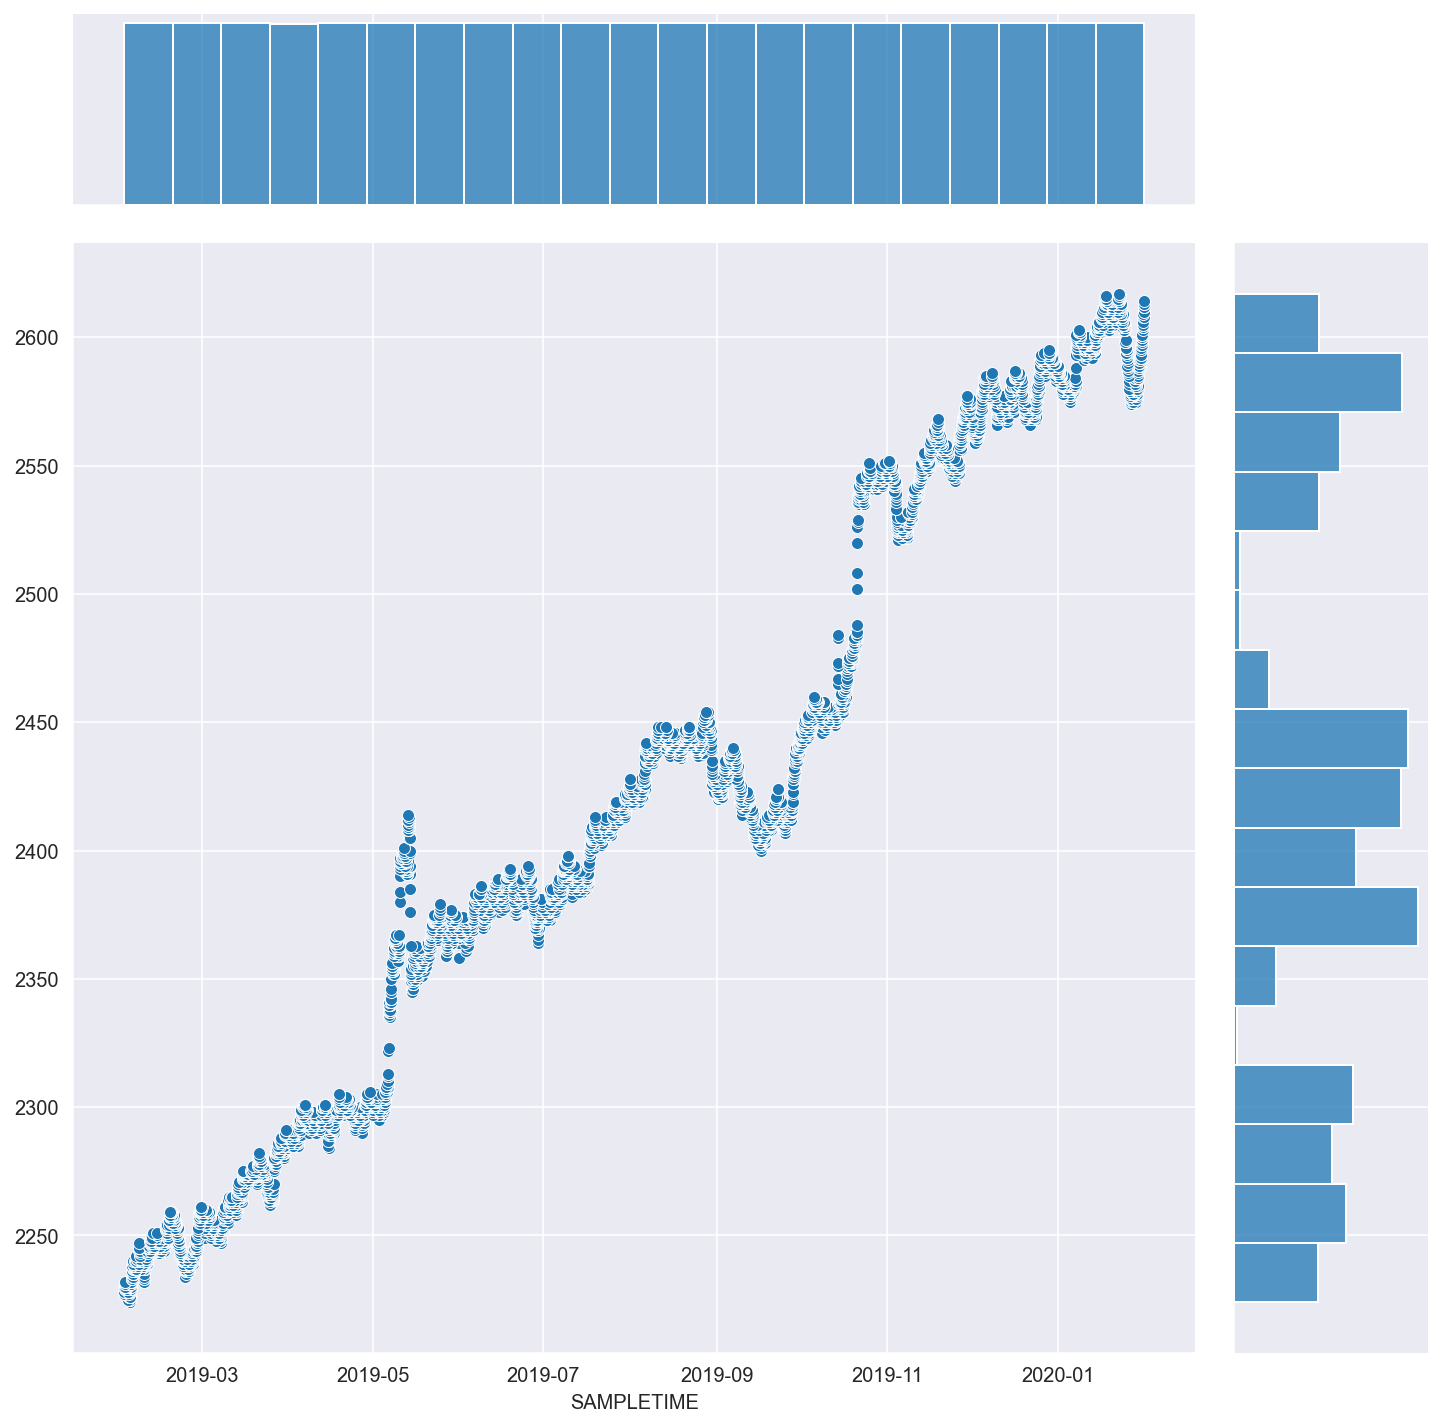

In [232]:
sns.jointplot(data=df.groupby(['SAMPLETIME']).size().sort_values(), kind='scatter', height=10)

<AxesSubplot:ylabel='Count'>

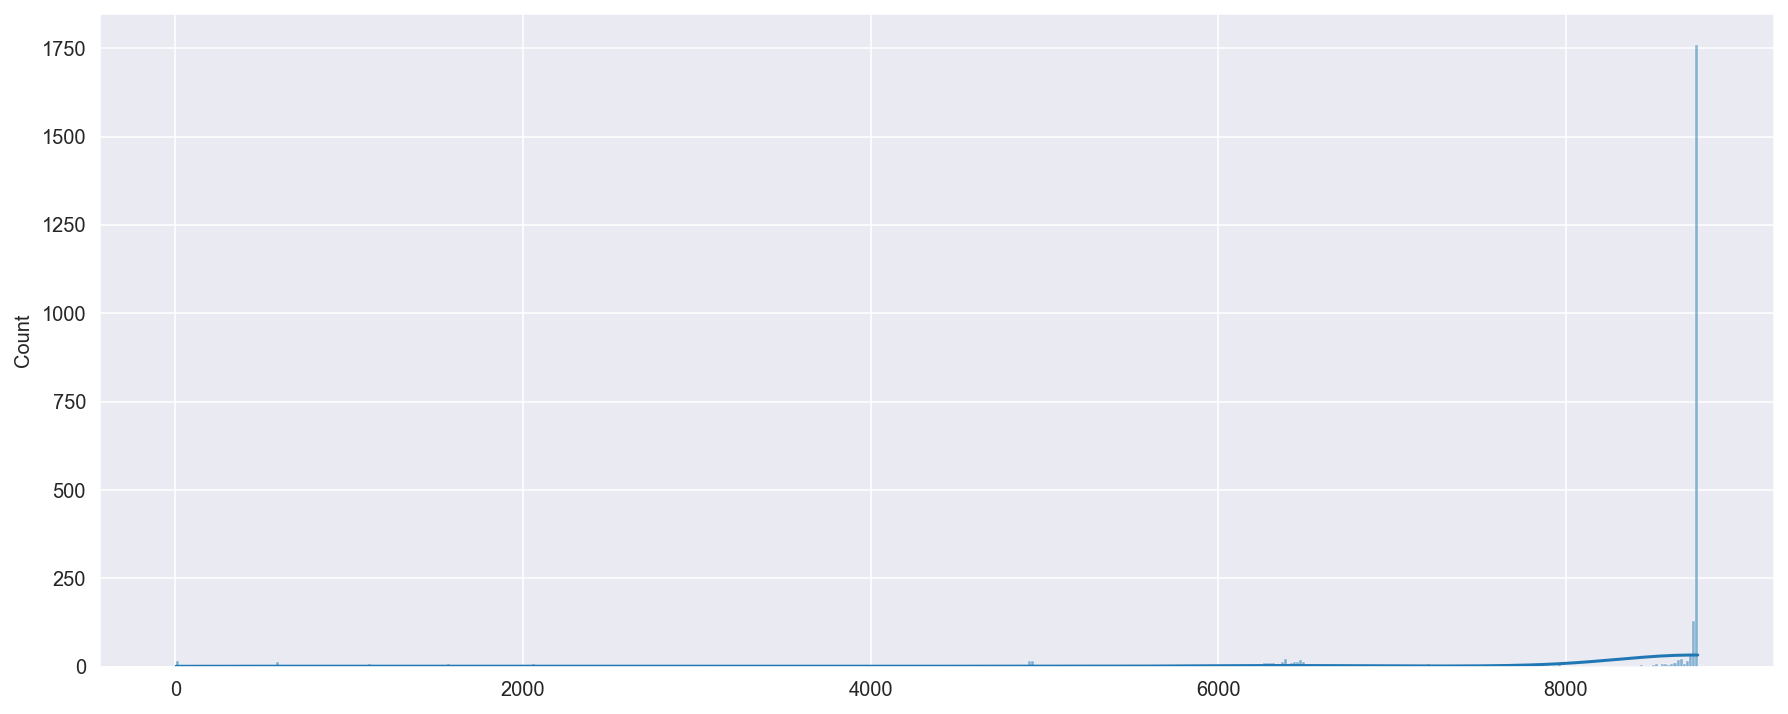

In [240]:
sns.histplot(df.groupby(['ID']).size().sort_values(), bins=500, kde=True)

### Ver si las horas se repiten ahora (antes de corregirlo arriba)

In [48]:
df_temp2 = df.groupby(['ID','SAMPLETIME']).size().sort_values()
unique2, counts2 = np.unique(df_temp2, return_counts=True)
dict(zip(unique2, counts2))

{1: 21264774, 3: 2, 4: 34882, 5: 104}

Podemos ver cómo aunque casi todas están bien, tenemos 2 ocurrencias de 3 horas repetidas, 104 de 5 y 34882 de 4 (cosa que ya sabíamos porque vimos que en algunos casos el contador contaba cada cuarto de hora)

Las de 4 van cada 15 minutos, pero en algunos casos sobre las 5 de la mañana meten un clock extra, en vez de a los minutos 15, 30 y 45 lo hacen a 14, 29, 44 y 59 (o similar).

Las de 3 son más peligrosas porque les falta un día, es decir, pasan del 2019-03-17 05:00:00 a 2019-03-18 05:15:00. Son las bases 248 y 1416 a la misma hora (2019-03-18 05:00:00), y los datos de consumos no se pierden, sino que en la hora siguiente hay un valor muy grande

In [26]:
df_temp[(df_temp != 1) & (df_temp != 4)].sort_index()

ID    SAMPLETIME         
248   2019-03-04 05:00:00    5
      2019-03-18 05:00:00    3
      2019-04-17 06:00:00    5
      2019-04-18 06:00:00    5
      2019-04-21 06:00:00    5
      2019-04-27 06:00:00    5
      2019-04-29 06:00:00    5
      2019-05-19 06:00:00    5
      2019-06-26 06:00:00    5
      2019-07-22 06:00:00    5
      2019-08-05 06:00:00    5
      2019-09-15 06:00:00    5
      2019-09-16 06:00:00    5
      2019-09-17 06:00:00    5
      2019-11-30 05:00:00    5
      2020-01-04 05:00:00    5
      2020-01-17 05:00:00    5
292   2019-03-17 05:00:00    5
      2019-03-27 05:00:00    5
      2019-04-19 06:00:00    5
      2019-04-23 06:00:00    5
      2019-06-09 06:00:00    5
      2019-06-24 06:00:00    5
      2019-07-27 06:00:00    5
      2019-07-29 06:00:00    5
      2019-09-07 06:00:00    5
      2019-09-18 06:00:00    5
      2019-09-29 06:00:00    5
      2019-10-25 06:00:00    5
      2019-10-27 05:00:00    5
      2019-11-07 05:00:00    5
      2019-12

Una vez hemos visto esto, vamos a normalizar en el apartado superior

### Ver si las horas se repiten ahora (después)

In [50]:
df_temp2 = df.groupby(['ID','SAMPLETIME']).size().sort_values()
unique2, counts2 = np.unique(df_temp2, return_counts=True)
dict(zip(unique2, counts2))

{1: 21299762}

Podemos ver cómo lo hemos corregido, y guardamos el nuevo archivo en un .csv

In [51]:
df.to_csv('data/Modelar_Procesado.csv')

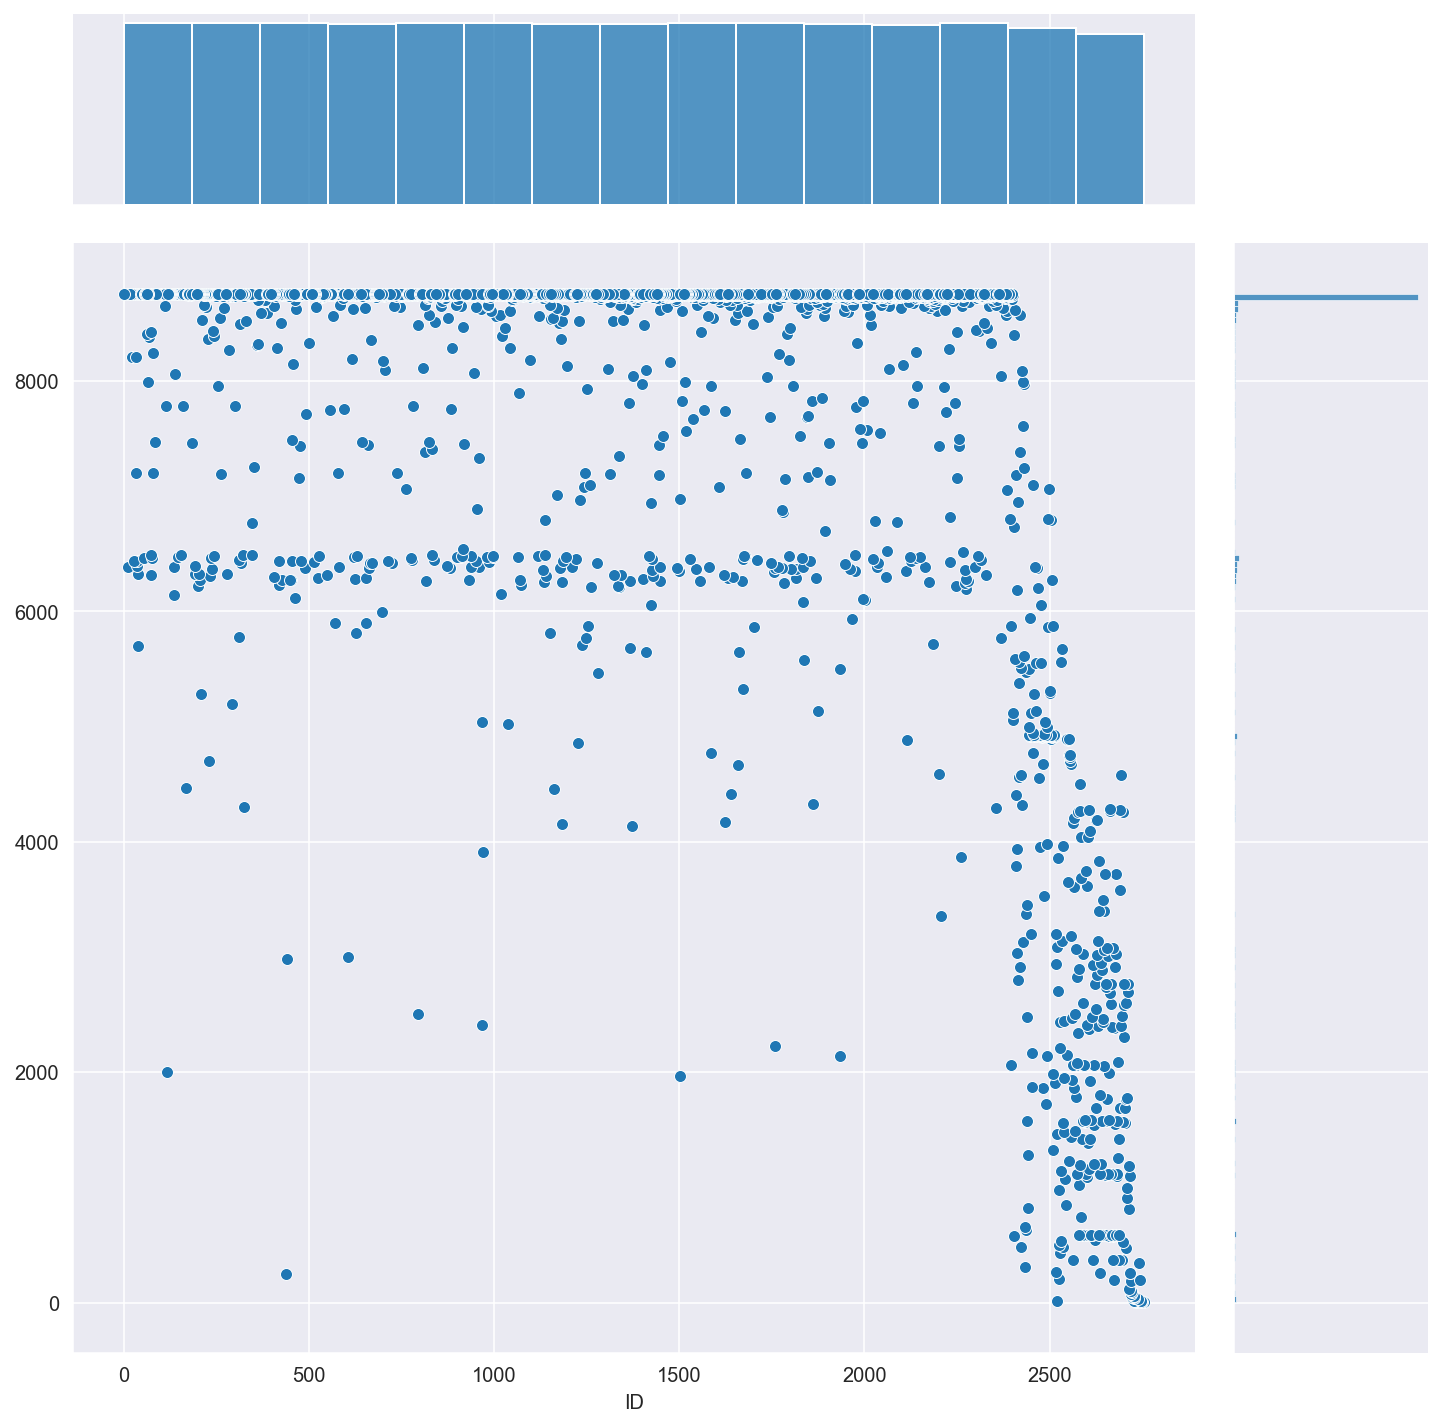

In [237]:
sns.jointplot(data=df.groupby(['ID']).size().sort_values(), kind='scatter', height=10)

## Crear variables cíclicas con sen/cos para mes, día, hora...

Pensar también qué hacer con el año

#### IMPORTANTE: Si usamos Random Forest, XGBoost... esto no funciona ya que no pueden procesar dos variables a la vez

## Ubicación

Cuidado, dice litoral de la Comunidad Valenciana pero podría ser Bacelona/Cataluña: "Agbar gestiona el suministro de agua de más de 1 millón de hogares, empresas y administraciones en más de 250 municipios de Cataluña y Baleares."

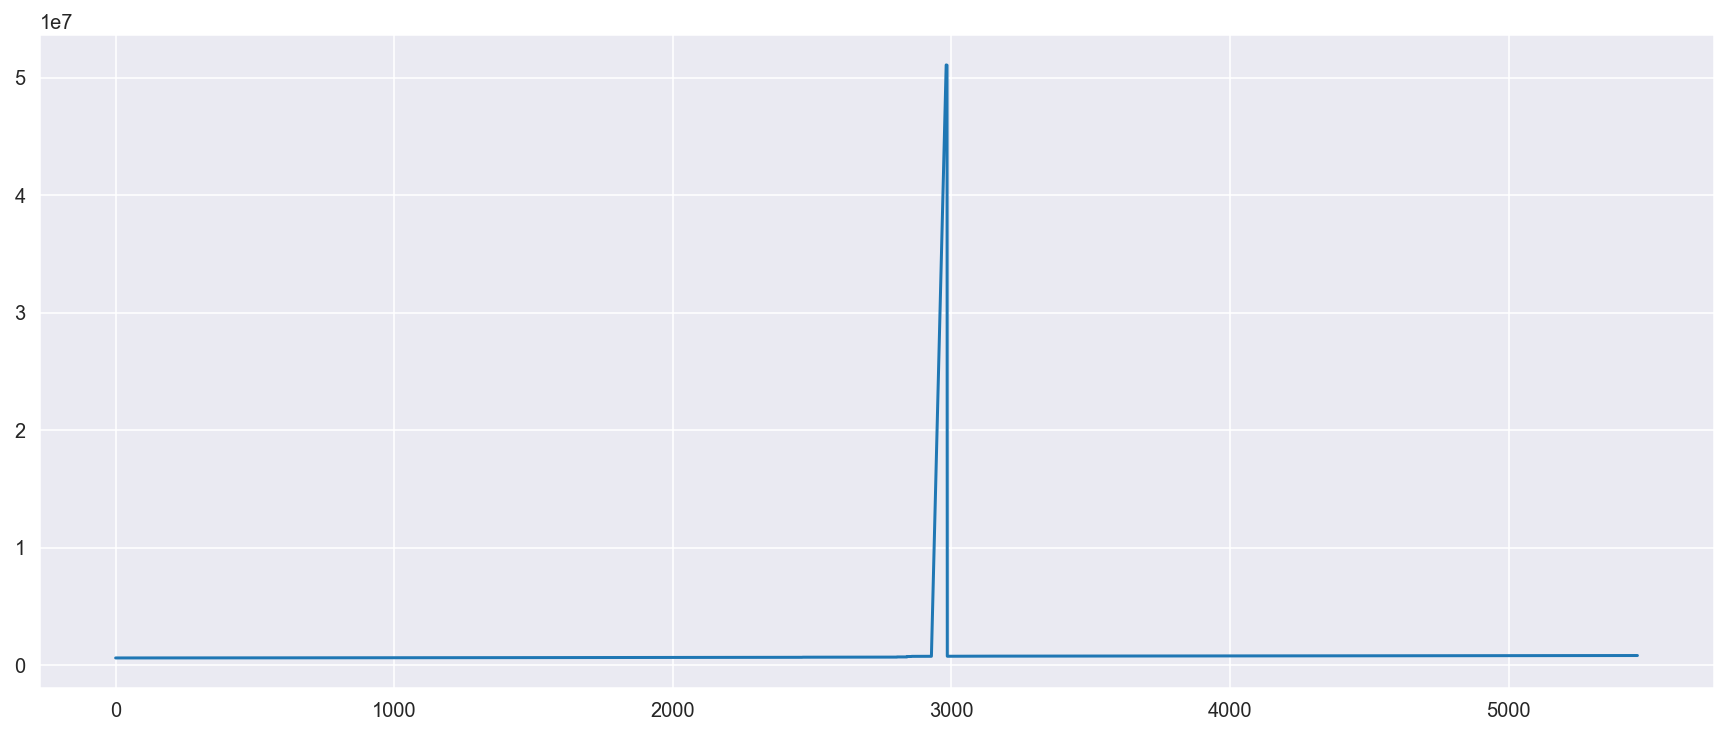

In [9]:
plt.plot(df.loc[1280    ].sort_values('SAMPLETIME')["READINGINTEGER"].values)

## Añadir día de la semana, o si es laboral o no

In [ ]:
MAS_FILTRO = [467, 795, 1036, 1247, 1280, 1410, 2370, 2417, 2419, 2434, 2448, 2459, 2461, 2467, 2472, 2479, 2488, 2495, 2509, 2512, 2534, 2536, 2615]
MENOS_FILTRO = [418, 516, 537, 741, 805, 1136, 1696]